In [1]:
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
import seaborn as sns

### processing survival data

In [24]:
clinical_file = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/tmp.txt",sep='\t',index_col=0)
clinical_file = clinical_file.iloc[1:,:]
clinical_file.index = clinical_file['patient_id']
survival_col = ['vital_status','days_to_initial_pathologic_diagnosis','days_to_death','days_to_last_followup','pathologic_stage','gender','age_at_initial_pathologic_diagnosis','race']
survival_data = clinical_file.loc[:,survival_col]

In [25]:
include_idx = survival_data['days_to_initial_pathologic_diagnosis'] == '0'
exclude_patient = list(survival_data.index[~include_idx])
survival_data = survival_data.loc[include_idx,:].copy()
### exclude crterion : both days_to_death & days_to_followup is missing value
#change days_to_death/days_to_last_followup to numeric
def numeric_survival(r) :
    if 'Not' not in r['days_to_death'] :
        return int(r['days_to_death'])
    else :
        return int(r['days_to_last_followup'])

survival_data['Survival_day'] = survival_data.apply(numeric_survival,axis=1)
# Status == True means patient dead in study period,else is False
survival_data['Status'] = np.where(survival_data['vital_status'] == 'Dead',True,False)
include_idx = np.where(survival_data['Survival_day'] > 0,True,False)
survival_data = survival_data.loc[include_idx,:].copy()

In [26]:
survival_data['pathologic_stage'].unique()
stage_without_subclass = ['Not Available', 'Stage I', 'Stage II', 'Stage III', 'Stage III',
       'Not Available', 'Stage III', 'Stage IV', 'Stage III',
       'Stage IV', 'Stage IV']
stage_d = dict(zip(survival_data['pathologic_stage'].unique(),stage_without_subclass))

In [31]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

exp_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_coding_gene_fpkm.txt",sep='\t',index_col=0)
patients = set(exp_df.columns).intersection(set(survival_data.index))
exp_matrix = exp_df.loc[:,patients]
survival_input = survival_data.loc[patients,['Status','Survival_day','pathologic_stage','gender','age_at_initial_pathologic_diagnosis','race']]
survival_input['pathologic_stage_without_subclass'] = survival_input['pathologic_stage'].map(stage_d)
for stage in survival_input['pathologic_stage_without_subclass'].unique() :
    survival_input[stage] = np.where(survival_input['pathologic_stage_without_subclass'] == stage,1,0)

### Time-dependent AUC-ROC in scikit-survival

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from sksurv.compare import compare_survival

In [8]:
def risk_from_cox(x,y):
    '''
    x : numpy array, information for cox regression training
    y : numpy array dtype=[('Status', '?'), ('Survival_in_days', '<f8')], input of sksurv result
    return 
    cph_risk_scores : cox-regression risk scores,
    c_index[0] : concordense index
    '''
    va_x_train, _, va_y_train, _ = train_test_split(x, y, test_size=0.2, stratify=y["Status"])
    cph = CoxnetSurvivalAnalysis(l1_ratio=1)
    cph.fit(va_x_train, va_y_train)
    #times = np.arange(100,1700,50) # type: ignore
    cph_risk_scores = cph.predict(x)
    c_index = concordance_index_censored(y["Status"], y["Survival_in_days"], cph_risk_scores)# type: ignore
    return cph_risk_scores,c_index[0]

def risk_from_cox_with_mask(x,y,mask_idx) :
    '''
    x : pd data frame, information for cox regression training
    y : numpy array dtype=[('Status', '?'), ('Survival_in_days', '<f8')], input of sksurv result
    mask_idx : list, which columns information will be mask in risk score prediction
    '''
    va_x_train, _, va_y_train, _ = train_test_split(x, y, test_size=0.2, stratify=y["Status"])
    cph = CoxnetSurvivalAnalysis(l1_ratio=1)
    cph.fit(va_x_train, va_y_train)
    #times = np.arange(100,1700,50) # type: ignore
    x.iloc[:,mask_idx] = 0
    cph_risk_scores = cph.predict(x)
    c_index = concordance_index_censored(y["Status"], y["Survival_in_days"], cph_risk_scores)# type: ignore
    return cph_risk_scores,c_index[0]

def km_plot(survival_data,y,title_dict,output_path) :

    plt.figure(figsize=(8,5))
    for treatment_type in ("High risk", "Low risk"):
        mask_treat = survival_data["Risk"] == treatment_type
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(y["Status"][mask_treat],y["Survival_in_days"][mask_treat])
        n_population = sum(survival_data['Risk'] == treatment_type)
        plt.step(time_treatment, survival_prob_treatment, where="post",label="Condition = %s (%d)" % (treatment_type,n_population))

    log_rank_result = compare_survival(y,survival_data["Risk"].values)
    plt.ylabel("Probability of survival S(t)")
    plt.xlabel("Time")
    plt.legend(loc="best")
    title = "%s : %s \n (Ngenes : %d,concordance index : %0.4f, log-rank p-value : %0.4f)" % (title_dict['GO'],title_dict['Description'],title_dict['Nnodes'],title_dict['c_index'],log_rank_result[1])
    plt.title(title)
    plt.savefig(output_path,dpi=300,bbox_inches='tight')
    plt.show()
    return log_rank_result[1]

def km_plot_with_stage(survival_data,y,title_dict,output_path) :

    plt.figure(figsize=(8,5))
    for treatment_type in ['Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Not Available']:
        mask_treat = survival_data['pathologic_stage_without_subclass'] == treatment_type
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(y["Status"][mask_treat],y["Survival_in_days"][mask_treat])
        n_population = sum(survival_data['pathologic_stage_without_subclass'] == treatment_type)
        plt.step(time_treatment, survival_prob_treatment, where="post",label="Condition = %s (%d)" % (treatment_type,n_population))

    plt.ylabel("Probability of survival S(t)")
    plt.xlabel("Time")
    plt.legend(loc="best")
    title = "%s : %s \n (Ngenes : %d,concordance index : %0.4f)" % (title_dict['GO'],title_dict['Description'],title_dict['Nnodes'],title_dict['c_index'])
    plt.title(title)
    plt.savefig(output_path,dpi=300,bbox_inches='tight')
    plt.show()

def edge2node(edge_context) :
        '''
        edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
        '''
        edge_l = edge_context.split('_')
        node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
        return list(node_l)

def module_kmplot_by_cox_regression(exp_profile,survival_data,module_df,output_dir,mask_idx=None,minMax=True):

    select_col = ['GOLV','Description','#Nodes','#Edges']
    stage_col = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
    report_df = module_df.loc[:,select_col]
    #processing survival data
    tmp = list(zip(survival_data['Status'],survival_data['Survival_day']))
    y = np.array(tmp,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    #standardize
    scaler = StandardScaler()
    stand_m = scaler.fit_transform(exp_profile.T.to_numpy())
    stand_df = pd.DataFrame(stand_m.T,index=exp_profile.index,columns=exp_profile.columns)
    if minMax :
        normalizer = MinMaxScaler()
        minMax_x = normalizer.fit_transform(stand_df.T.to_numpy())
        stand_df = pd.DataFrame(minMax_x.T,index=stand_df.index,columns=stand_df.columns)
    #report value
    c_index_array = np.zeros(module_df.shape[0]) ; log_rank_array = np.zeros(module_df.shape[0])
    l_risk_median = np.zeros(module_df.shape[0]) ; h_risk_median = np.zeros(module_df.shape[0])

    for idx,go in enumerate(module_df.index) :
        e = module_df.loc[go,'Edges']
        gene_list = list(set(edge2node(e)).intersection(exp_profile.index))
        exp_matrix = stand_df.loc[gene_list,survival_data.index].T
        exp_matrix = pd.concat([exp_matrix,survival_data.loc[:,stage_col]],axis=1)
        if mask_idx :
            risk_score,c_index = risk_from_cox_with_mask(exp_matrix,y,mask_idx)
        else :
            risk_score,c_index = risk_from_cox(exp_matrix,y)
        km_input = survival_data.copy()
        km_input['Risk'] = np.where(risk_score > 0 ,'High risk','Low risk')
        if minMax and mask_idx != None:
            fig_path = output_dir + "%s_minMax_masked.png" % go
        elif minMax :
            fig_path = output_dir + "%s_minMax.png" % go
        else :
            fig_path = output_dir + "%s.png" % go
        title_dict = {'GO' : go,'Description' : module_df.loc[go,'Description'],'Nnodes' : len(gene_list),'c_index' : c_index} 
        log_rank_p = km_plot(km_input,y,title_dict,fig_path)
        #report value
        c_index_array[idx] = c_index ; log_rank_array[idx] = log_rank_p
        l_risk_median[idx] = np.median(risk_score[risk_score <= 0])
        h_risk_median[idx] = np.median(risk_score[risk_score > 0])
    report_df['c_index'] = c_index_array
    report_df['log_rank_pvalue'] = log_rank_array
    report_df['l_risk_score_median'] = l_risk_median
    report_df['h_risk_score_median'] = h_risk_median
    return report_df

def module_survival_input(exp_profile,survival_data,module_df,output_path,minMax=True) :

    select_col = ['GOLV','Description','#Nodes','#Edges']
    #processing survival data
    tmp = list(zip(survival_data['Status'],survival_data['Survival_day']))
    y = np.array(tmp,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    #standardize
    scaler = StandardScaler()
    stand_m = scaler.fit_transform(exp_profile.T.to_numpy())
    stand_df = pd.DataFrame(stand_m.T,index=exp_profile.index,columns=exp_profile.columns)
    if minMax :
        normalizer = MinMaxScaler()
        minMax_x = normalizer.fit_transform(stand_df.T.to_numpy())
        stand_df = pd.DataFrame(minMax_x.T,index=stand_df.index,columns=stand_df.columns)

    for go in module_df.index :
        e = module_df.loc[go,'Edges']
        des = module_df.loc[go,'Description'].replace(" ","-")
        gene_list = list(set(edge2node(e)).intersection(exp_profile.index))
        exp_matrix = stand_df.loc[gene_list,survival_data.index].T
        exp_matrix = pd.concat([survival_data,exp_matrix],axis=1)
        exp_matrix.to_csv(output_path + '%s_%s.txt' % (go,des),sep='\t')
        print("Survival info for %s is completed !" % go)
    


def module_risk_score_boxplot_by_cox_regression(exp_profile,survival_data,module_df,title,fig_output_path,minMax=True):

    select_col = ['GOLV','Description','#Nodes','#Edges']
    stage_col = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
    #processing survival data
    tmp = list(zip(survival_data['Status'],survival_data['Survival_day']))
    y = np.array(tmp,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    #standardize
    scaler = StandardScaler()
    stand_m = scaler.fit_transform(exp_profile.T.to_numpy())
    stand_df = pd.DataFrame(stand_m.T,index=exp_profile.index,columns=exp_profile.columns)
    if minMax :
        normalizer = MinMaxScaler()
        minMax_x = normalizer.fit_transform(stand_df.T.to_numpy())
        stand_df = pd.DataFrame(minMax_x.T,index=stand_df.index,columns=stand_df.columns)
    #report value
    plot_df = pd.DataFrame()
    #normalize risk score to 1,-1 scale
    risk_score_normalize = lambda x,max_value,min_value : x / max_value if x > 0 else -1 * x / min_value

    for go in module_df.index :
        e = module_df.loc[go,'Edges']
        gene_list = list(set(edge2node(e)).intersection(exp_profile.index))
        exp_matrix = stand_df.loc[gene_list,survival_data.index].T
        exp_matrix = pd.concat([exp_matrix,survival_data.loc[:,stage_col]],axis=1)
        risk_score,_ = risk_from_cox(exp_matrix,y)
        normalized_risk_score = list(map(risk_score_normalize,risk_score,[max(risk_score)] * len(risk_score),[min(risk_score)] * len(risk_score)))
        risk_score_df = pd.DataFrame({'Stage' : survival_data['pathologic_stage_without_subclass'],
                                      'Risk_score' : normalized_risk_score,'Description' : [module_df.loc[go,'Description'] + '\n(%d genes)' % len(gene_list)] * len(risk_score)},index=survival_data.index)
        plot_df = pd.concat([plot_df,risk_score_df])
    
    plt.figure(figsize=(12,7))
    sns.boxplot(data=plot_df,x='Description',y='Risk_score',hue='Stage',palette='Set3',showfliers=True)
    if len(plot_df['Description'].unique()) > 4 :
        plt.xticks(rotation=90)
    plt.ylabel('Normalized risk score')
    plt.title(title)
    plt.savefig(fig_output_path,dpi=300,bbox_inches='tight')
    

### tmp

In [2]:
def format_coxph_summary(summary,condition,go,description) :

    gene_list = list(summary.index)[6:]
    summary = summary.loc[gene_list,["Pr(>|z|)","z"]]
    summary.loc[gene_list,"Gene"] = gene_list
    summary.loc[gene_list,"Go"] = [go] * summary.shape[0]
    summary.loc[gene_list,"Description"] = [description] * summary.shape[0] 
    summary.loc[gene_list,"Condition"] = [condition] * summary.shape[0] 
    summary = summary.reset_index()
    summary.rename(columns={'Pr(>|z|)' : 'p-value'},inplace=True)
    summary.drop(['index'],axis=1,inplace=True)
    col_order = ["Gene","p-value",'z','Go',"Description",'Condition']

    return summary.loc[:,col_order]

def format_coxph_summary_filename(name) :

    ppi = name.split("_")[1]
    condition = name.split("_")[2] + '_' + name.split("_")[3] + '_' + name.split("_")[4]
    go = name.split("_")[5]
    des = name.split("_")[6]

    return ppi,condition,go,des


def one_hot_encoding_stage_2_single_col(df) :
    stage_col = [str(x) for x in df.columns[4:8].values]
    #change ens to hgsc
    stage = []
    for i in range(df.shape[0]) :
        idx = np.where(df.iloc[i,4:9] == 1)
        s = stage_col[idx[0][0]]
        stage.append(s)
    df.insert(4,'Stage',stage)
    df.drop(stage_col,axis=1,inplace=True)
    return df

In [19]:
res_path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/5year_coxph_summary/"
file_list = os.listdir(res_path)
grn_summary = pd.DataFrame()
pin_summary = pd.DataFrame()
for file in file_list :
    ppi,condition,go,des = format_coxph_summary_filename(file)
    lihc_df = pd.read_csv(res_path + file,sep='\t',index_col=0)
    liri_df = pd.read_csv(res_path + file.replace('lihc','liri'),sep='\t',index_col=0)
    lihc_res = format_coxph_summary(lihc_df,condition,go,des)
    liri_res = format_coxph_summary(liri_df,condition,go,des)
    lihc_res.insert(2,"liri_p-value",lihc_res['p-value'])

    if ppi == 'GRN' :
        grn_summary = pd.concat([grn_summary,lihc_res])
    else :
        pin_summary = pd.concat([pin_summary,lihc_res])

def significant_gene_in_funmodule(cox_summary) :

    sig_df = cox_summary.loc[np.where((cox_summary['p-value'] < 0.05) & (cox_summary['liri_p-value']< 0.05),True,False),:].sort_values(by='Gene')

    tmp = sig_df.groupby(["Gene"]).count().reset_index()
    count_d = dict(zip(tmp['Gene'].values,tmp['p-value'].values))
    sig_df['#Nmodule'] = sig_df['Gene'].map(count_d)
    sig_df = sig_df.sort_values(by='#Nmodule',ascending=False)
    sig_df.reset_index()
    sig_df.drop(['z'],axis=1,inplace=True)
    
    return sig_df


In [20]:
sig_grn = significant_gene_in_funmodule(grn_summary)
sig_pin = significant_gene_in_funmodule(pin_summary)

In [22]:
sig_grn.to_csv("cox_regression_summary_of_GRN_module.txt",sep='\t')
sig_pin.to_csv("cox_regression_summary_of_PIN_module.txt",sep='\t')

In [77]:
grn_candidate = ["CSF1R","CXCL10","SELPLG"]

pin_candidate = ['HLA.A', 'SDC4', 'HLA.DRB1', 'HLA.DRA', 'MT.ATP8', 'ATP5MG', 'CSNK2B','ISG15', 'ATP5F1D', 'CASP1', 'CARD16']

In [ ]:
for ppi in ["GRN","PIN"] :
    for sheet in ["hbv_only_35","tumor_only_25"] :
        path = "/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/survival_input/lihc_%s_%s/" % (ppi,sheet)
        module_df = pd.read_excel("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi, sheet_name=sheet,index_col=1)
        file_list = os.listdir(path)
        for f in file_list :
            file = path + f
            print(file)
            df = pd.read_csv(file,sep='\t',index_col=0)
            #change ens to hgsc
            col = []
            stage_col = [str(x) for x in df.columns[4:9].values]
            stage = []
            for i in range(df.shape[0]) :
                idx = np.where(df.iloc[i,4:9] == 1)
                s = stage_col[idx[0][0]]
                stage.append(s)
            df.insert(4,'Stage',stage)
            df.drop(stage_col,axis=1,inplace=True)
            df.to_csv(file ,sep='\t')

In [ ]:
sheet_list = ['hbv_only_35','tumor_only_25']
fig_output = '/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/'
if os.path.exists(fig_output) == False :
    os.mkdir(fig_output)
report_df = pd.DataFrame()
for ppi in ['GRN','PIN'] :
    for sheet in sheet_list :
        print("Survival input for %s : %s" % (ppi,sheet))
        df = pd.read_excel("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi, sheet_name=sheet,index_col=1)
        fig_folder = fig_output + 'lihc_' + ppi + '_' +sheet + '/'
        if os.path.exists(fig_folder) == False :
            os.mkdir(fig_folder)
        module_survival_input(exp_matrix,survival_input,df,fig_folder)

### baseline kmplot by stage information

In [ ]:
fig_output = '/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/survival_km_plot/'
stage_col = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
#processing survival data
tmp = list(zip(survival_input['Status'],survival_input['Survival_day']))
y = np.array(tmp,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
x = survival_input.loc[:,stage_col].to_numpy()
risk_score,c_index = risk_from_cox(x,y)
km_input = survival_input.copy()
km_input['Risk'] = np.where(risk_score > 0 ,'High risk','Low risk')
log_rank_result = compare_survival(y,km_input["Risk"].values)
title_dict = {'GO' : '','Description' : 'Kapier meier survival curve by one-hot encoding stage information','Nnodes' : 0,'c_index' : c_index} 
title = "TCGA-LIHC Kapler-Meier survival curve of one-hot encoding stage information \n (Concordance index : %0.2f, log-rank p-value : %0.4f)" % (c_index,log_rank_result[1])
log_rank_p = km_plot(km_input,y,title,fig_output + 'tcga_stage_km_plot1.png')

In [ ]:
sheet_list = ['hbv_only_35','tumor_only_25']
fig_output = '/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/survival_km_plot/'
if os.path.exists(fig_output) == False :
    os.mkdir(fig_output)
report_df = pd.DataFrame()
for ppi in ['GRN','PIN'] :
    for sheet in sheet_list :
        df = pd.read_excel("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi, sheet_name=sheet,index_col=1)
        fig_folder = fig_output + 'lihc_' + ppi + '_' +sheet + '/'
        if os.path.exists(fig_folder) == False :
            os.mkdir(fig_folder)
        try :
            module_df = module_kmplot_by_cox_regression(exp_matrix.T,survival_input,df,fig_folder,mask_idx=[-1,-2,-3,-4])
        except :
            continue
        #risk score boxplot
        '''
        risk_score_title = 'Risk score distribution in different stage in %s functional module (%s)' % (ppi,sheet)
        boxplot_df = module_risk_score_boxplot_by_cox_regression(exp_matrix.T,survival_input,df,risk_score_title,fig_folder+"%s_risk_score_boxplot_%s.png" % (ppi,sheet))
        module_df['Condition'] = [sheet.split('_')[0]] * module_df.shape[0]
        report_df = pd.concat([report_df,module_df])
        '''
    #report_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/LIHC_%s_survival_summary.txt" % ppi,sep='\t')

### LIRI-JP survival

In [9]:
liri_path = '/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/LIRI_JP/'
liri_survival = pd.read_csv(liri_path + 'liri_jp_survival.txt',sep='\t',index_col=0)
liri_metadata = pd.read_csv(liri_path + 'metadata.txt',sep='\t',index_col=0)
liri_exp = pd.read_csv(liri_path + 'liri_jp_coding_gene_ensid_fpkm_matrix.txt',sep='\t',index_col=0)

In [10]:
cancer_idx = liri_metadata['Sample_type'] == 'Cancer'
doner = liri_metadata.loc[cancer_idx,'icgc_donor_id'].values
doner_dict = dict(zip(doner,liri_metadata.index[cancer_idx]))

liri_survival.index.name = None
doner = list(set(doner).intersection(liri_survival.index))
liri_survival = liri_survival.loc[doner,:]
liri_survival.index = [doner_dict[x] for x in liri_survival.index]
liri_survival['Stage'] = liri_metadata.loc[liri_survival.index,'Stage']

In [14]:
#stage one-hot encoding 
stage_list = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
stage_dict = {'Stage I' : 1, 'Stage II' : 2, 'Stage III' : 3, 'Stage IV' : 4}
for stage in stage_list :
    liri_survival[stage] = np.where(liri_survival['Stage'] == stage_dict[stage],1,0)
#format survival data
sample = list(set(liri_survival.index).intersection(liri_exp.columns))
liri_survival = liri_survival.loc[sample,:]
liri_survival['Status'] = np.where(liri_survival['donor_vital_status'] == 'deceased',True,False)
tmp = list(zip(liri_survival['Status'],liri_survival['donor_survival_time']))
y= np.array(tmp,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
#
data = liri_exp.loc[:,sample]
survival_input = liri_survival.loc[:,['donor_survival_time','Status','donor_sex','donor_age_at_diagnosis']+stage_list]
survival_input.columns = ['Survival_day','Status','Sex','Age'] + stage_list

In [16]:
survival_input.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/icgc_liri_survival_info.txt",sep='\t')

### ICGC-LIRI baseline kmplot by one-hot encoding stage information

In [16]:
def km_plot(survival_data,y,title,output_path) :

    plt.figure(figsize=(8,5))
    for treatment_type in ("High risk", "Low risk"):
        mask_treat = survival_data["Risk"] == treatment_type
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(y["Status"][mask_treat],y["Survival_in_days"][mask_treat])
        n_population = sum(survival_data['Risk'] == treatment_type)
        plt.step(time_treatment, survival_prob_treatment, where="post",label="Condition = %s (%d)" % (treatment_type,n_population))

    log_rank_result = compare_survival(y,survival_data["Risk"].values)
    plt.ylabel("Probability of survival S(t)")
    plt.xlabel("Time")
    plt.legend(loc="best")
    plt.title(title)
    plt.savefig(output_path,dpi=300,bbox_inches='tight')
    plt.show()
    return log_rank_result[1]

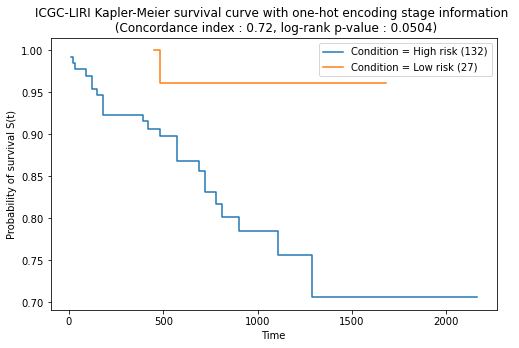

In [28]:
fig_output = '/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/survival_km_plot/'
stage_col = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
#processing survival data
tmp = list(zip(survival_input['Status'],survival_input['Survival_day']))
y = np.array(tmp,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
x = survival_input.loc[:,stage_col].to_numpy()
risk_score,c_index = risk_from_cox(x,y)
km_input = survival_input.copy()
km_input['Risk'] = np.where(risk_score > 0 ,'High risk','Low risk')
log_rank_result = compare_survival(y,km_input["Risk"].values)
title_dict = {'GO' : '','Description' : 'Kapier meier survival curve by one-hot encoding stage information','Nnodes' : 0,'c_index' : c_index} 
title = "ICGC-LIRI Kapler-Meier survival curve with one-hot encoding stage information \n (Concordance index : %0.2f, log-rank p-value : %0.4f)" % (c_index,log_rank_result[1])
log_rank_p = km_plot(km_input,y,title,fig_output + 'icga_liri_stage_km_plot1.png')

In [22]:
sheet_list = ['hbv_only_35','tumor_only_25']
fig_output = '/home/bruce1996/data/LIHC_anomaly_detection/survival_analysis/'
if os.path.exists(fig_output) == False :
    os.mkdir(fig_output)
report_df = pd.DataFrame()
for ppi in ['GRN','PIN'] :
    for sheet in sheet_list :
        print("Survival input for %s : %s" % (ppi,sheet))
        df = pd.read_excel("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi, sheet_name=sheet,index_col=1)
        fig_folder = fig_output + 'liri_' + ppi + '_' +sheet + '/'
        if os.path.exists(fig_folder) == False :
            os.mkdir(fig_folder)
        module_survival_input(data,survival_input,df,fig_folder)

Survival input for GRN : hbv_only_35
Survival info for GO:0045824 is completed !
Survival info for GO:0071346 is completed !
Survival info for GO:0071345 is completed !
Survival input for GRN : tumor_only_25
Survival info for GO:0071345 is completed !
Survival info for GO:0070106 is completed !
Survival info for GO:0035456 is completed !
Survival input for PIN : hbv_only_35
Survival info for GO:0002286 is completed !
Survival info for GO:1903037 is completed !
Survival info for GO:0002709 is completed !
Survival info for GO:0019885 is completed !
Survival info for GO:0002484 is completed !
Survival info for GO:0050870 is completed !
Survival info for GO:0051251 is completed !
Survival info for GO:0042098 is completed !
Survival info for GO:0071345 is completed !
Survival info for GO:0002711 is completed !
Survival info for GO:0002690 is completed !
Survival info for GO:0002486 is completed !
Survival info for GO:0050670 is completed !
Survival info for GO:0002456 is completed !
Surviva